# Disk model

In [1]:
import numpy as np
import random
import math
from tabulate import tabulate
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#a=list(np.linspace(0,np.pi/2,100))
#a.remove(a[0])
#a.remove(a[len(a)-1])
#alpha=random.choices(a, k=1)  
alpha=[np.pi/4]

Wiener Process; 

-Wiener(n, 2, T).T[0]- the first independent Wiener proces

-Wiener(n, 2, T). T[1]- the second independent Wiener process

In [3]:
def Wiener(n, d, T):  #n is the number of time steps, d is the dimension of the Wiener process and T is the end time of simulation
    times=np.linspace(0, T, n)  #equally distanced n time steps
    dt=times[1]-times[0]        
    dB=np.sqrt(dt)*np.random.normal(size=(n-1, d)) #dB=Wt2-Wt1 has a normal distribution with mean 0 and variance t2-t1=dt
    B0=np.zeros(shape=(1,d))    #Wiener process starts at 0
    B=np.concatenate((B0,np.cumsum(dB, axis=0)), axis=0) #to find the Wt1, we add up all differences till Wt1-W(t1-dt)
    return B

In [4]:
def sin(x):   #cruicial functions for this model
    return np.sin(x)

def cos(x):
    return np.cos(x)

In [5]:
#N=3000   #the number of the simulations of the process (of the for loop)
#time=100  #consider this time as an ending point
def Diskmodel(time, N, n, mu1, mu2, s11, s22, mu, s): #n is the number of time steps, (mu1, mu2) is the drift vector; ((s11, 0),(0, s22)) is the sigma matrix; mu and s are included in the circular Wiener process
    times=np.linspace(0, time, n)   #timestep is time/n 
    worst_best={"A1A2F":0, "A1FA2":0, "A2A1F":0, "A2FA1":0, "FA1A2":0, "FA2A1":0}
    result={"Option1":0, "Option2":0, "Fall_back_option":0} #dictionary to keep record of the times each of the option is chosen
    stopping_times=[]
    episodes=np.zeros((2, N))  #record the time each episode of the process ends
    times_A1_favorite=[]
    times_A2_favorite=[]
    times_F_favorite=[]
    times_A1_least_favorite=[]
    times_A2_least_favorite=[]
    times_F_least_favorite=[]
    alpha1=alpha[0]   #fix the randomly chosen alpha angle
    for i in range(N):
    #X(t)=(X1(t), X2(t))
    #X1=mu1*t+s11*W1, 
    #X2=mu2*t+s22*W2, 
        X1=np.ones(n)*mu1*times+s11*np.ones(n)*np.array(Wiener(n, 2, time).T[0]) #array code which finds the value of X1 for each t in times
        X2=np.ones(n)*mu2*times+s22*np.ones(n)*np.array(Wiener(n, 2, time).T[1])  #array code which finds the value of X2 for each t in times
        X1new=X1*X1
        X2new=X2*X2
        Y=X1new+X2new
        a=[element for element in Y if element>=1]  #vectors which touched the disc boundary
        k1=list(Y).index(a[0])    #the index of the first vector which touched the disc boundary
        angle=math.atan2(X2[k1], X1[k1])     #get the angle of such vector
        if - alpha1<=angle<=alpha1:          #condition 1, the process hit the accept boundary of the first option 
            stopping_times.append(times[k1])    #the process is over; obtain the stopping time
            episodes[0,i]=times[k1]
            episodes[1,i]=0
            result["Option1"]+=1              #based on the range of angles, the first option was chosen
            val1=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])  
            val2=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])
            a1=list(map(cos, val1))    #the first component of the vector (circular Wiener process with drift)
            a2=list(map(sin, val2))    #the second component of the vector (circular Wiener process with drift)     
            a=[k for k in range(len(times)) if alpha1<=math.atan2(a2[k],a1[k])<=np.pi-alpha1 or -np.pi+alpha1<=math.atan2(a2[k],a1[k])<=-alpha1]  #the conditions of the 
            times_A1_favorite.append(times[k1])

            if len(a)>0:
                 
                if alpha1<=math.atan2(a2[a[0]], a1[a[0]])<=np.pi-alpha1:  #the accept boundary of the second option is hit
                     
                    worst_best["A1A2F"]+=1
                    times_F_least_favorite.append(times[k1]+times[a[0]])
                elif -np.pi+alpha1<=math.atan2(a2[a[0]], a1[a[0]])<=-alpha1:  #the reject boundary of the second option is hit
                        
                    worst_best["A1FA2"]+=1
                    times_A2_least_favorite.append(times[k1]+times[a[0]])
        elif alpha1<=angle<=np.pi-alpha1:     #condition 2; the process hit the accept boundary of the second option
            stopping_times.append(times[k1])   #stopping time
            episodes[0,i]=times[k1]
            episodes[1,i]=0
            result["Option2"]+=1              #option 2 is chosen
            val1=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])
            val2=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])
            a1=list(map(cos, val1))   #the first component of the circular Wiener process with drift 
            a2=list(map(sin, val2))    #the second component of the circular Wiener proces with drift
            b=[k for k in range(len(times)) if -alpha1<=math.atan2(a2[k], a1[k])<=alpha1 or np.pi-alpha1<=math.atan2(a2[k], a1[k])<=np.pi or -np.pi<=math.atan2(a2[k], a1[k])<=-np.pi+alpha1]  #the conditions describing the angles in the underlying process
            times_A2_favorite.append(times[k1])
            if len(b)>0:
                if -alpha1<=math.atan2(a2[b[0]], a1[b[0]])<=alpha1:  #the accept boundary of the first option is hit
                    worst_best["A2A1F"]+=1  
                    times_F_least_favorite.append(times[k1]+times[b[0]])
                    
                elif np.pi-alpha1<=math.atan2(a2[b[0]], a1[b[0]])<=np.pi or -np.pi<=math.atan2(a2[b[0]], a1[b[0]])<=-np.pi+alpha1:  #the reject boundary of the first option is hit
                
                    worst_best["A2FA1"]+=1
                    times_A1_least_favorite.append(times[k1]+times[b[0]])
        elif np.pi-alpha1<=angle<=np.pi or -np.pi<=angle<=-np.pi+alpha1:     #condition 3, the process first hits the reject boundary of the first option; process continues as a circular Wiener process
            #val1=np.array(v1*times)+np.array(v2*np.array(Wiener(n,1,time).T[0]))
            val1=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])  
            val2=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])
            a1=list(map(cos, val1))    #the first component of the vector (circular Wiener process with drift)
            a2=list(map(sin, val2))    #the second component of the vector (circular Wiener process with drift) 
            a=[k for k in range(len(times)) if alpha1<=math.atan2(a2[k],a1[k])<=np.pi-alpha1 or -np.pi+alpha1<=math.atan2(a2[k],a1[k])<=-alpha1]  #the conditions of the underlying process
            times_A1_least_favorite.append(times[k1])
            episodes[0,i]=times[k1]
            if len(a)>0:
                stopping_times.append(times[a[0]]+times[k1])   #this is the stopping time of the process
                if alpha1<=math.atan2(a2[a[0]], a1[a[0]])<=np.pi-alpha1:  #the accept boundary of the second option is hit
                    result["Option2"]+=1      #the second option is chosen
                    worst_best["A2FA1"]+=1
                    times_A2_favorite.append(times[k1]+times[a[0]])
                    episodes[1,i]=times[a[0]]
                elif -np.pi+alpha1<=math.atan2(a2[a[0]], a1[a[0]])<=-alpha1:  #the reject boundary of the second option is hit
                    result["Fall_back_option"]+=1    #the fall back option is chosen
                    worst_best["FA2A1"]+=1
                    times_F_favorite.append(times[k1]+times[a[0]])
                    episodes[1,i]=times[a[0]]
        else:  #the reject boundary of the second option is hit
            val1=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])
            val2=angle*np.ones(len(times))+mu*times+s*np.array(Wiener(n,1,time).T[0])
            a1=list(map(cos, val1))   #the first component of the circular Wiener process with drift 
            a2=list(map(sin, val2))    #the second component of the circular Wiener proces with drift
            b=[k for k in range(len(times)) if -alpha1<=math.atan2(a2[k], a1[k])<=alpha1 or np.pi-alpha1<=math.atan2(a2[k], a1[k])<=np.pi or -np.pi<=math.atan2(a2[k], a1[k])<=-np.pi+alpha1]  #the conditions describing the angles in the underlying process
            times_A2_least_favorite.append(times[k1])
            episodes[0,i]=times[k1]
            if len(b)>0:
                stopping_times.append(times[b[0]]+times[k1])   #stopping time
                if -alpha1<=math.atan2(a2[b[0]], a1[b[0]])<=alpha1:  #the accept boundary of the first option is hit
                    result["Option1"]+=1     #the process is over and the option 1 is chosen
                    worst_best["A1FA2"]+=1
                    times_A1_favorite.append(times[k1]+times[b[0]])
                    episodes[1,i]=times[b[0]]
                elif np.pi-alpha1<=math.atan2(a2[b[0]], a1[b[0]])<=np.pi or -np.pi<=math.atan2(a2[b[0]], a1[b[0]])<=-np.pi+alpha1:  #the reject boundary of the first option is hit
                    result["Fall_back_option"]+=1  #process ends and the fall back option is chosen
                    worst_best["FA1A2"]+=1
                    times_F_favorite.append(times[k1]+times[b[0]])
                    episodes[1,i]=times[b[0]]
    #return ("The choice probabilities for option 1, option 2, and fall back option are {}, {}, and {} respectively. The mean of stoping times is {}. According to the paper, the choice probabilities for option 1, option 2, and fall back option are {}, {}, and {} respectively").format(result["Option1"]/N, result["Option2"]/N, result["Fall_back_option"]/N, np.mean(np.array(stoping_t
    data=[[worst_best["A1A2F"]/N, worst_best["A1FA2"]/N,worst_best["A2A1F"]/N, worst_best["A2FA1"]/N,worst_best["FA1A2"]/N, worst_best["FA2A1"]/N],[np.mean(times_A1_favorite), np.mean(times_A2_favorite), np.mean(times_F_favorite)],[np.mean(times_A1_least_favorite), np.mean(times_A2_least_favorite), np.mean(times_F_least_favorite)]]
    if [mu1, mu2, s11, s22,mu,s]==[0,0,1,1,0,1]:
        return "The choice probabilities for option 1, option 2, and fall back option are {}, {}, and {} respectively. The mean of reaction time is {}. According to the paper, the choice probabilities for option 1, option 2, and fall-back option are {}, {}, and {} respectively".format(result["Option1"]/N, result["Option2"]/N, result["Fall_back_option"]/N, np.mean(stopping_times), alpha1/(2*np.pi)+0.25, 0.25+((np.pi/2)-alpha1)/(2*np.pi), 0.25), stopping_times, data, episodes, "The mean of the stopping times of the first and second episode of the process are {} and {} respectively".format(np.mean(episodes[0]), np.mean(episodes[1]))  
    else:
        return "The choice probabilities for option 1, option 2, and fall-back option are {}, {}, and {} respectively. The mean of reaction time is {}.".format(result["Option1"]/N, result["Option2"]/N, result["Fall_back_option"]/N, np.mean(stopping_times)), stopping_times, data, episodes, "The mean of the stopping times of the first and second episode of the process are {} and {} respectively".format(np.mean(episodes[0]), np.mean(episodes[1]))


In [6]:
summary, reaction_time, worst_best, episodes, info_episodes=Diskmodel(100, 3000, 20000,0, 0, 1, 1,0,1)


Find the choice probability for each option and mean of the reaction time of the process:

In [7]:
summary

'The choice probabilities for option 1, option 2, and fall back option are 0.39366666666666666, 0.37366666666666665, and 0.23266666666666666 respectively. The mean of reaction time is 0.828944780572362. According to the paper, the choice probabilities for option 1, option 2, and fall-back option are 0.375, 0.375, and 0.25 respectively'

Display the probability distribution of the reaction time random variable (the vertical line denotes the mean):

C:\Users\Dania\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


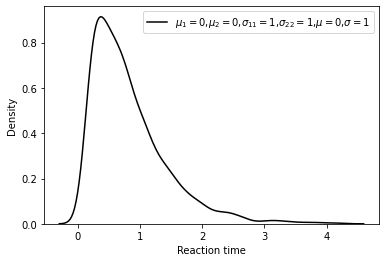

In [8]:
sns.distplot(reaction_time, color="black", hist=False, norm_hist=True,axlabel="Reaction time", label=r"$\mu_{1}=0$,$\mu_{2}=0$,$\sigma_{11}=1$,$\sigma_{22}=1$,$\mu=0$,$\sigma=1$")
#plt.axvline(np.mean(reaction_time), color="red")
#sns.distplot(reaction_time1, color="blue", hist=False, norm_hist=True,axlabel="Reaction time", label=r"$\mu_{1}=2$,$\mu_{2}=2.3$,$\sigma_{11}=3$,$\sigma_{22}=3.3$,$\mu=2$,$\sigma=3$")
#sns.distplot(reaction_time2, color="red",hist=False, norm_hist=True,axlabel="Reaction time", label=r"$\mu_{1}=4$,$\mu_{2}=4$,$\sigma_{11}=5$,$\sigma_{22}=5$,$\mu=0$,$\sigma=1$")

plt.legend()

Find the choice probabilities of each of worst-best scenarios and of the possibilities describing each of the options as being the most/least preferred, and the corresponding mean time:

In [9]:
head1=["P[A1A2F]".translate(SUB), "P[A1FA2]".translate(SUB), "P[A2A1F]".translate(SUB), "P[A2FA1]".translate(SUB), "P[FA1A2]".translate(SUB), "P[FA2A1]".translate(SUB)]            
mydata1=[worst_best[0]] #the probabilities of each of the worst_best scenarios
df1=pd.DataFrame(mydata1,columns=head1)
df1

,P[A₁A₂F],P[A₁FA₂],P[A₂A₁F],P[A₂FA₁],P[FA₁A₂],P[FA₂A₁]
0,0.133,0.260667,0.128333,0.245333,0.116667,0.116


In [10]:
head2=["P[A1 is the most preferred option]".translate(SUB), "P[A2 is the most preferred option]".translate(SUB), "P[F is the most preferred option]".translate(SUB)]
mydata2=[[worst_best[0][0]+worst_best[0][1],worst_best[0][2]+worst_best[0][3], worst_best[0][4]+worst_best[0][5]]] #the probabilities for the scenarios where options A1, A2, F are the most preferred ones
df2=pd.DataFrame(mydata2, columns=head2)
df2

,P[A₁ is the most preferred option],P[A₂ is the most preferred option],P[F is the most preferred option]
0,0.393667,0.373667,0.232667


In [11]:
head3=["P[A1 is the least preferred option]".translate(SUB), "P[A2 is the least preferred option]".translate(SUB), "P[F is the least preferred option]".translate(SUB)]
mydata3=[[worst_best[0][3]+worst_best[0][5],worst_best[0][1]+worst_best[0][4],worst_best[0][2]+worst_best[0][0]]]  #the probabilities for the scenarios where options A1, A2, F are the most preferred ones
df3=pd.DataFrame(mydata3, columns=head3)
df3

,P[A₁ is the least preferred option],P[A₂ is the least preferred option],P[F is the least preferred option]
0,0.361333,0.377333,0.261333


In [12]:
head4=["A1 most preferred / mean time".translate(SUB),"A2 most preferred / mean time".translate(SUB),"F most preferred / mean time".translate(SUB)]
mydata4=[worst_best[1]]  #the mean of the times determining the choice of options A1, A2, F as the most preferred one respectively
df4=pd.DataFrame(mydata4, columns=head4)
df4

,A₁ most preferred / mean time,A₂ most preferred / mean time,F most preferred / mean time
0,0.746278,0.737811,1.115178


In [13]:
head5=["A1 least preferred / mean time".translate(SUB),"A2 least preferred / mean time".translate(SUB),"F least preferred / mean time".translate(SUB)]  #the mean of the times determining the choice of options A1, A2, F as the most preferred one respectively
mydata5=[worst_best[2]]
df5=pd.DataFrame(mydata5, columns=head5)
df5

,A₁ least preferred / mean time,A₂ least preferred / mean time,F least preferred / mean time
0,0.730479,0.749795,1.087197


Plot the joint distribution of the times corresponding to the end of the first and second episode:

<ipython-input-16-c1e4cd467289>:32: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

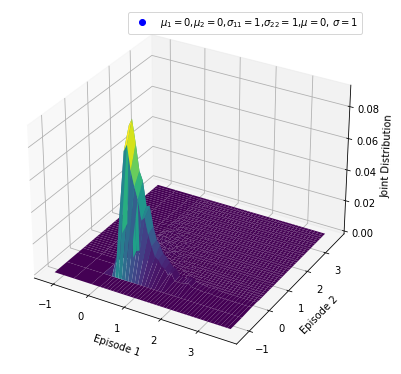

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib as mpl
a=[episodes[0].min()-1.5, episodes[0].min()-1, episodes[0].min()-0.4]    
b=[episodes[1].min()-1.5, episodes[1].min()-1, episodes[1].min()-0.4]
for l in range(41):
    a.append(episodes[0].min()+l*(episodes[0].max()-episodes[0].min())/40)  #divide the interval of possible values of stopping times in the first and second episode into 20 equal parts
    b.append(episodes[1].min()+l*(episodes[1].max()-episodes[1].min())/40)
    
c=np.zeros((len(a)-1, len(b)-1))  #create a matrix to keep track of the "joint frequencies" intervalwise
valuesa_valuesb=[]
x=[(a[i+1]+a[i])/2 for i in range(len(a)-1)]  #first episode
y=[(b[k+1]+b[k])/2 for k in range(len(b)-1)]   #second episode
#frequency: 
#N corresponds to the number of simulations
N=3000
for i in range(len(a)-1):
    for k in range(len(b)-1):
        for m in range(N):
            if a[i]<=episodes[0, m]<=a[i+1] and b[k]<=episodes[1, m]<= b[k+1]:  #joint occurence
                c[i, k]+=1
                valuesa_valuesb.append([i,k])
            else:
                pass
           
c=c/N
X,Y =np.meshgrid(x,y)
Z=c.T  
fig=plt.figure()
#ax=plt.axes(projection="3d")
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6, 5))
#ax = Axes3D(fig, elev=45, azim=-120)
ax=Axes3D(fig)
ax.plot_surface(X,Y,Z,cmap="viridis") #3d plot
ax.legend()  
ax.set_xlabel("Episode 1")
ax.set_ylabel("Episode 2")
ax.set_zlabel("Joint Distribution")
fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([fake2Dline], [r"$\mu_{1}=0$,$\mu_{2}=0$,$\sigma_{11}=1$,$\sigma_{22}=1$,$\mu=0$, $\sigma=1$"])
plt.show()
#plt.savefig("Pic_1.png")

Another view of the plot: facing Episode 2

<ipython-input-17-f7112de51cea>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


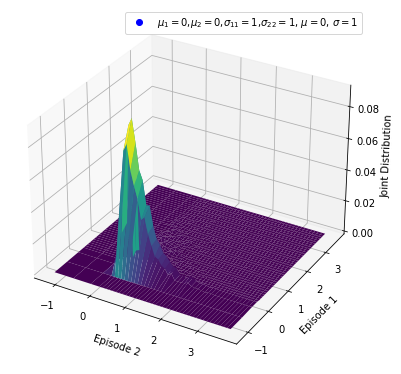

In [17]:
import matplotlib as mpl
fig = plt.figure(figsize=(6, 5))     
#ax = Axes3D(fig, elev=45, azim=-120)
ax=Axes3D(fig)
ax.plot_surface(Y,X,c,cmap="viridis") #3d plot
ax.legend()  
ax.set_xlabel("Episode 2")
ax.set_ylabel("Episode 1")
ax.set_zlabel("Joint Distribution")
fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([fake2Dline], [r"$\mu_{1}=0$,$\mu_{2}=0$,$\sigma_{11}=1$,$\sigma_{22}=1$, $\mu=0$, $\sigma=1$"])
plt.show()
#plt.savefig("Pic_2.png")

Find the mean of the stopping times in each episode:

In [18]:
print(info_episodes)



The mean of the stopping times of the first and second episode of the process are 0.5496191476240478 and 0.2793256329483141 respectively


Display the distribution of the stopping times of each of two episodes:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


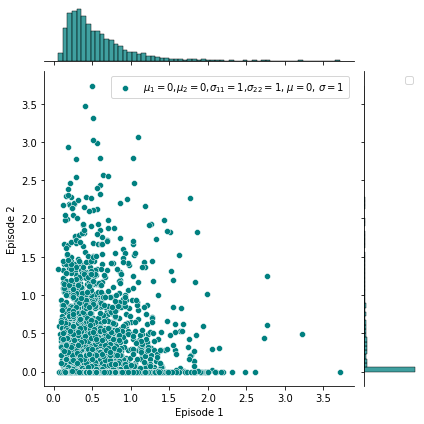

In [19]:
episodes_new_Disk=pd.DataFrame({"Episode 1": episodes[0], "Episode 2": episodes[1]})
sns.jointplot(x="Episode 1",y="Episode 2", data=episodes_new_Disk, color="teal", label=r"$\mu_{1}=0$,$\mu_{2}=0$,$\sigma_{11}=1$,$\sigma_{22}=1$, $\mu=0$, $\sigma=1$")
plt.legend()
#plt.savefig("1.png")